In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_parquet('data/yellow_tripdata_2023-01.parquet')

In [3]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [4]:
data.columns.shape

(19,)

In [5]:
data.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

In [6]:
x = (data.tpep_dropoff_datetime - data.tpep_pickup_datetime).loc[0]
x.total_seconds()/60

8.433333333333334

In [7]:
data['duration'] = data.tpep_dropoff_datetime - data.tpep_pickup_datetime
data['duration'] = data.duration.apply(lambda duration: duration.total_seconds() / 60)

In [8]:
data.duration.std()

42.594351241920904

In [9]:
data.duration.describe(percentiles=[.1, .2, .3, .25, .50, .75, .98, .99])

count    3.066766e+06
mean     1.566900e+01
std      4.259435e+01
min     -2.920000e+01
10%      4.483333e+00
20%      6.283333e+00
25%      7.116667e+00
30%      7.950000e+00
50%      1.151667e+01
75%      1.830000e+01
98%      4.873333e+01
99%      5.725000e+01
max      1.002918e+04
Name: duration, dtype: float64

<AxesSubplot:xlabel='duration', ylabel='Count'>

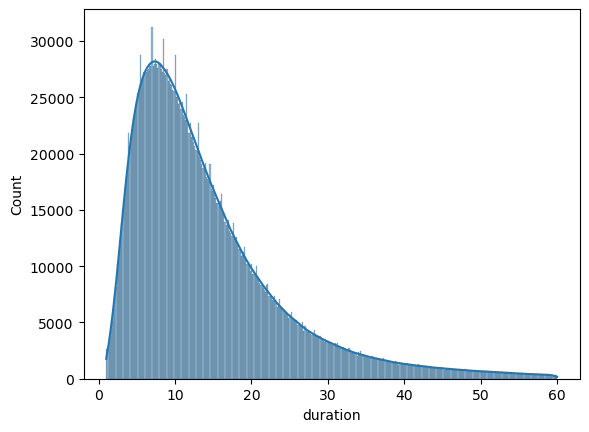

In [10]:
sns.histplot(data[(data.duration >= 1) & (data.duration <= 60)].duration, kde=True)

In [11]:
data[(data.duration >= 1) & (data.duration <= 60)].shape[0] / data.shape[0] * 100

98.1220282212598

In [12]:
data = data[(data.duration >= 1) & (data.duration <= 60)]

In [13]:
data.duration.std()

9.939385620145579

In [14]:
location_features = ['PULocationID', 'DOLocationID']
num_features = ['trip_distance']
target_col = ['duration']

In [15]:
data[location_features] = data[location_features].astype(str)
data[location_features + num_features + target_col].dtypes

PULocationID      object
DOLocationID      object
trip_distance    float64
duration         float64
dtype: object

In [16]:
data.loc[data[location_features[1]].isna(), location_features]

,PULocationID,DOLocationID


In [25]:
def read_data(path):
    data = pd.read_parquet(path)
    data['duration'] = data.tpep_dropoff_datetime - data.tpep_pickup_datetime
    data['duration'] = data.duration.apply(lambda duration: duration.total_seconds() / 60)
    data = data[(data.duration >= 1) & (data.duration <= 60)]

    location_features = ['PULocationID', 'DOLocationID']
    data[location_features] = data[location_features].astype(str)
    
    return data

In [26]:
val_data = read_data('./data/yellow_tripdata_2023-02.parquet')

In [27]:
train_set = data[location_features].to_dict(orient='records')
val_set = val_data[location_features].to_dict(orient='records')

In [18]:
dict_vectorizer = DictVectorizer()
x_train = dict_vectorizer.fit_transform(train_set)

In [29]:
x_val = dict_vectorizer.transform(val_set)

In [19]:
len(dict_vectorizer.feature_names_)

515

In [28]:
target = data[target_col].values
val_target = val_data[target_col].values

In [21]:
lr = LinearRegression()
lr.fit(x_train, target)

LinearRegression()

In [22]:
mean_squared_error(target, lr.predict(x_train), squared=False)

7.649262029221019

In [30]:
mean_squared_error(val_target, lr.predict(x_val), squared=False)

7.8118169669491095

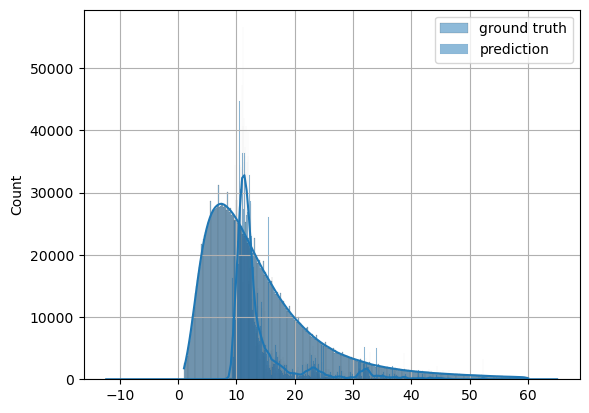

In [23]:
sns.histplot(target, kde=True, label='ground truth')
sns.histplot(lr.predict(x_train), kde=True, label='prediction')
plt.legend()
plt.grid()

In [24]:
lr.predict(x_train).max(), lr.predict(x_train).min()

(64.97331661052884, -12.339407572554627)

### combine features

In [32]:
data['PU_DU'] = data.PULocationID + '_' + data.DOLocationID
val_data['PU_DU'] = val_data.PULocationID + '_' + val_data.DOLocationID

In [37]:
train_set = data[['PU_DU']].to_dict(orient='records')
val_set = val_data[['PU_DU']].to_dict(orient='records')
dict_vectorizer = DictVectorizer()
x_train = dict_vectorizer.fit_transform(train_set)

In [38]:
x_val = dict_vectorizer.transform(val_set)

In [39]:
lr = LinearRegression()
lr.fit(x_train, target)

LinearRegression()

In [40]:
mean_squared_error(target, lr.predict(x_train), squared=False)

5.026739090626736

In [41]:
mean_squared_error(val_target, lr.predict(x_val), squared=False)

5.198556981102852